# Libraries

In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from scipy import integrate

# Function

In [2]:
def gaussian_quadrature(n):
        # n: number of points
        # w: weight 
        # x: point of integration
        
        if n == 1:
            w = np.array([2])
            x = np.array([0])
        elif n == 2:
            w = np.array([1, 1])
            x = np.array([-1/np.sqrt(3), 1/np.sqrt(3)])
        elif n == 3:
            w = np.array([5/9, 8/9, 5/9])
            x = np.array([-np.sqrt(3/5), 0, np.sqrt(3/5)])
        elif n == 4:
            w = np.array([ (18-np.sqrt(30))/36, (18+np.sqrt(30))/36, (18+np.sqrt(30))/36, (18-np.sqrt(30))/36 ])
            x = np.array([ -np.sqrt(3/7 + 2/7*np.sqrt(6/5)), -np.sqrt(3/7 - 2/7*np.sqrt(6/5)), np.sqrt(3/7 - 2/7*np.sqrt(6/5)), np.sqrt(3/7 + 2/7*np.sqrt(6/5)) ])
        
        return x, w

# Input data

In [3]:
L = 1                       # Beam length    
q = 100                     # load
nel = 512                  # number of elements
nnos = nel + 1              # number of nodes   
alldof = np.linspace(1, 1,2*nnos) # all degrees of freedom
kg = np.zeros((2*nnos,2*nnos)) # global stiffness matrix pre-allocation
I = 100                     # inertia
E = 210e9                   # young's modulus   
coord = np.zeros((nnos, 3)) # coordinate matrix pre-allocation
inci = np.zeros((nel, 6))   # incidence matrix pre-allocation
f = np.zeros((2*nnos, 1))  # external load vector

# Coordinate matrix

In [4]:
for i in range(0, nnos):
    coord[i,0] = i + 1      # node number
    coord[i,1] = i*L/nel    # node position
    coord[i,2] = 0
l = coord[1,1] - coord[0,1] # element length

# Incidence matrix

In [5]:
for i in range(0, nel):   
    inci[i,0] = i + 1          # element number
    inci[i,1] = i + 1          # first node
    inci[i,2] = i + 2          # second node
    inci[i,3] = coord[i,1]     # first node coordinate
    inci[i,4] = coord[i+1,1]   # second node coordinate
    inci[i,5] = I              # inertia of beam section

# Boundary conditions

In [6]:
#   bc=[node | degree of freedom | value]
#
#   Degree of freedom 1 --> y
#   Degree of freedom 2 --> oz

bc = np.array([[1,1,0],[1,2,0]])

# Mask stiffness matrix

In [7]:
mask = np.zeros((2*nnos,2*nnos))
for i in range(0, np.size(bc,0)):
    if bc[i,1] == 1:
        mask[2*bc[i,0]-2,2*bc[i,0]-2] = 1
    elif bc[i,1] == 2:
        mask[2*bc[i,0]-1,2*bc[i,0]-1] = 1
mask = ma.masked_equal(mask, 1)
mask = ma.mask_rowcols(mask)
mask = (mask==False)

# Mask load vector

In [8]:
maskv = np.zeros(2*nnos)
for i in range(0, np.size(bc,0)):
    if bc[i,1] == 1:
        maskv[2*bc[i,0]-2] = 1
    elif bc[i,1] == 2:
        maskv[2*bc[i,0]-1] = 1
maskv = ma.masked_equal(maskv, 1)
maskv = (maskv==False)

#  Load vector

In [9]:
#   F = [node | degree of freedom | value]
#
#   Degree of freedom 1 --> Fy
#   Degree of freedom 2 --> Mz
def Q(x, q, L):
    Q = q + 3/4*q/L**2*x**2 - 7/4*q/L*x
    return Q

def phi(x, L):
    phi = np.array([[2*x**3/L**3 - 3*x**2/L**2 + 1], [x - 2*x**2/L + x**3/L**2], [3*x**2/L**2 - 2*x**3/L**3], [x**3/L**2 - x**2/L]])
    return phi


n = 3
x,w = gaussian_quadrature(n)
fg = np.zeros((2*nnos,1))

for i in range(nel):
    node1 = inci[i,1]  # first node element
    node2 = inci[i,2]  # second node element

    loc = [2*node1-2,2*node1-1,2*node2-2,2*node2-1]

    coord1 = coord[int(node1) - 1, 1] # node 1 position
    coord2 = coord[int(node2) - 1, 1] # node 2 position

    fe = np.zeros((4,1))   # local load vector 

    Q_ = 0
    for j in range(n):

        epsilon = (coord2 - coord1)/2*x[j] + (coord2 + coord1)/2     
        fe = fe + ((coord2 - coord1)/2)*Q(epsilon  , q, L)*phi(epsilon, L)*w[j] 
    
    print(fe)

    fg[[int(loc[0]),int(loc[1]),int(loc[2]),int(loc[3])]] = fg[[int(loc[0]),int(loc[1]),int(loc[2]),int(loc[3])]] + fe



[[ 1.94978158e-01]
 [ 1.89805449e-04]
 [ 7.42423792e-07]
 [-2.47353663e-07]]
[[ 1.94307270e-01]
 [ 5.65713924e-04]
 [ 5.17594463e-06]
 [-1.72350615e-06]]
[[ 1.93633124e-01]
 [ 9.36102944e-04]
 [ 1.39853521e-05]
 [-4.65397156e-06]]
[[ 1.92955782e-01]
 [ 1.30101791e-03]
 [ 2.71081277e-05]
 [-9.01507920e-06]]
[[ 1.92275306e-01]
 [ 1.66050399e-03]
 [ 4.44821425e-05]
 [-1.47833277e-05]]
[[ 1.91591758e-01]
 [ 2.01460614e-03]
 [ 6.60456564e-05]
 [-2.19353844e-05]]
[[ 1.90905200e-01]
 [ 2.36336910e-03]
 [ 9.17373171e-05]
 [-3.04480849e-05]]
[[ 1.90215692e-01]
 [ 2.70683739e-03]
 [ 1.21496159e-04]
 [-4.02984328e-05]]
[[ 1.89523296e-01]
 [ 3.04505531e-03]
 [ 1.55261602e-04]
 [-5.14635988e-05]]
[[ 1.88828070e-01]
 [ 3.37806694e-03]
 [ 1.92973451e-04]
 [-6.39209203e-05]]
[[ 1.88130075e-01]
 [ 3.70591613e-03]
 [ 2.34571894e-04]
 [-7.76479012e-05]]
[[ 1.87429371e-01]
 [ 4.02864655e-03]
 [ 2.79997503e-04]
 [-9.26222110e-05]]
[[ 1.86726017e-01]
 [ 4.34630161e-03]
 [ 3.29191230e-04]
 [-1.08821685e-04]]

In [10]:
fg

array([[ 1.94978158e-01],
       [ 1.89805449e-04],
       [ 1.94308012e-01],
       ...,
       [-4.35868227e-07],
       [ 4.78697065e-05],
       [-6.21784113e-08]])

# Global matrix assembly

In [11]:
for i in range(nel):
    node1 = inci[i,1] # first node element
    node2 = inci[i,2] # second node element
    
    # local stiffness matrix
    inertia = inci[i,5]
    ke = E*inertia/l**3*np.array([[12, 6*l, -12, 6*l], [6*l, 4*l**2, -6*l, 2*l**2], [-12, -6*l, 12, -6*l],  [6*l, 2*l**2, -6*l, 4*l**2]])
    
    # localization vector
    loc = [2*node1-2,2*node1-1,2*node2-2,2*node2-1]
    
    # global stiffness matrix 
    kg[[[int(loc[0])],[int(loc[1])],[int(loc[2])], [int(loc[3])]], [int(loc[0]),int(loc[1]),int(loc[2]),int(loc[3])]] = kg[[[int(loc[0])],[int(loc[1])],[int(loc[2])], [int(loc[3])]], [int(loc[0]),int(loc[1]),int(loc[2]),int(loc[3])]] +  ke
    
kg_aux = kg[mask.data]
kg_aux = np.reshape(kg_aux, (2*nnos-np.size(bc,0), 2*nnos-np.size(bc,0)))
f_aux  = fg[maskv.data]

# Displacement

In [12]:
u = np.zeros((2*nnos, 1))
u[maskv.data] = np.linalg.solve(kg_aux, f_aux)
u_ = np.reshape(u,(nnos,2))
displacement = u_[:,0]
rotation = u_[:,1]

# Post-processing

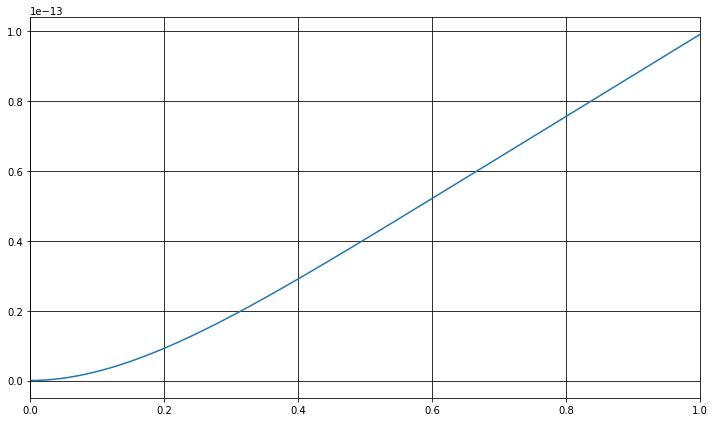

In [13]:
coord[:,2] = displacement
fig, ax = plt.subplots(figsize = (12, 7))

plt.plot(coord[:,1],coord[:,2])
plt.xlim([0,1])
plt.grid(b=True, which='major', color='k', linestyle='-')
fig.savefig('fem_lista_2_Q4.png',dpi=300)                              # salvar figura como png (dpi = número de pixels)

In [14]:
displacement

array([0.00000000e+00, 1.09348803e-18, 4.36508864e-18, 9.80149907e-18,
       1.73894189e-17, 2.71155509e-17, 3.89666025e-17, 5.29292861e-17,
       6.89903206e-17, 8.71364321e-17, 1.07354355e-16, 1.29630833e-16,
       1.53952619e-16, 1.80306478e-16, 2.08679188e-16, 2.39057536e-16,
       2.71428327e-16, 3.05778378e-16, 3.42094522e-16, 3.80363609e-16,
       4.20572505e-16, 4.62708095e-16, 5.06757283e-16, 5.52706991e-16,
       6.00544163e-16, 6.50255763e-16, 7.01828779e-16, 7.55250219e-16,
       8.10507117e-16, 8.67586529e-16, 9.26475538e-16, 9.87161251e-16,
       1.04963080e-15, 1.11387135e-15, 1.17987009e-15, 1.24761424e-15,
       1.31709104e-15, 1.38828777e-15, 1.46119173e-15, 1.53579027e-15,
       1.61207076e-15, 1.69002059e-15, 1.76962721e-15, 1.85087808e-15,
       1.93376070e-15, 2.01826261e-15, 2.10437139e-15, 2.19207465e-15,
       2.28136002e-15, 2.37221520e-15, 2.46462790e-15, 2.55858589e-15,
       2.65407695e-15, 2.75108893e-15, 2.84960970e-15, 2.94962718e-15,
      